In [58]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf

In [35]:
btc = yf.Ticker("BTC-USD").history(period='6y')['Close']

In [36]:
len(btc)

2191

## Stationarity

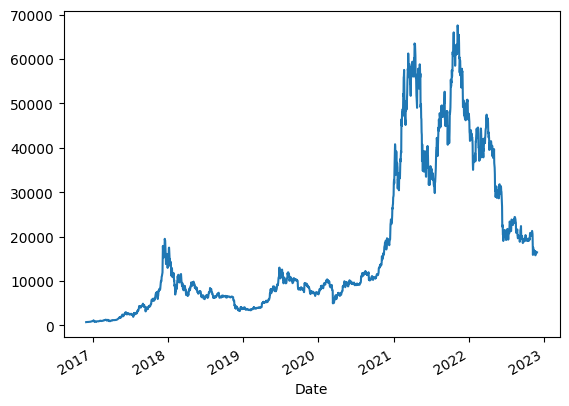

In [37]:
btc.plot.line();

In [38]:
from statsmodels.tsa.stattools import adfuller

In [39]:
result1 = adfuller(btc, autolag='AIC')
print(f'ADF Statistic: {result1[0]}')
print(f'p-value: {result1[1]}')

ADF Statistic: -1.5501281395754434
p-value: 0.5085841880959042


pvalue over 0.05 therefore we fail to reject the null hypothesis, therefore data is not stationary.

## Autocorrelation

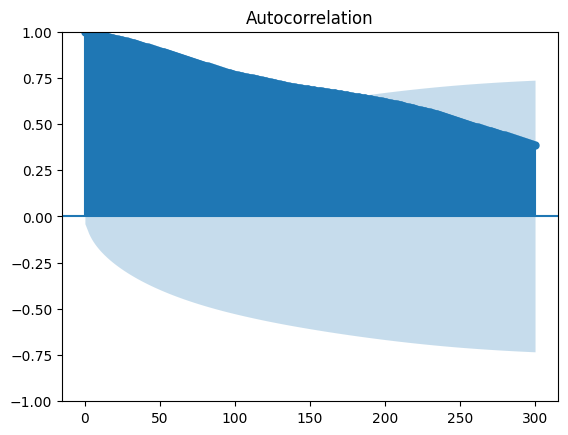

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

# Calculate the ACF (via statsmodel)
plot_acf(btc, lags=300 )

# Show the data as a plot (via matplotlib)
plt.show();

We have autocorrelation up to 180 day lag

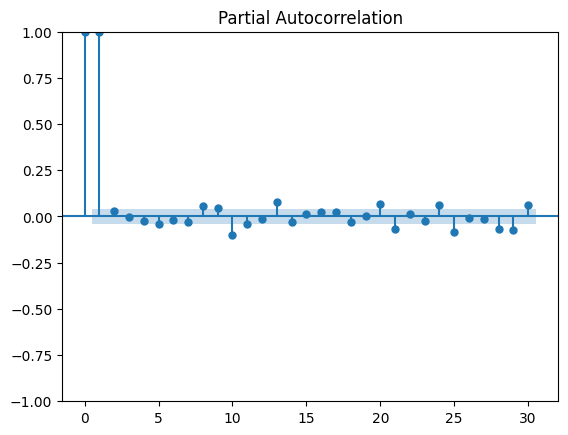

In [50]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

plot_pacf(btc, alpha =0.05, lags=30)

plt.show();

No major significant partial autocorrelation 

In [69]:
btc_stationary = btc.diff().dropna()

In [74]:
result1 = adfuller(btc_stationary, autolag='AIC')
print(f'ADF Statistic: {result1[0]}')
print(f'p-value: {result1[1]}')

ADF Statistic: -8.03096243845379
p-value: 1.95894665170155e-12


Now we have stationary data

In [75]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [112]:
stepwise_fit = pm.auto_arima(btc_stationary, start_p=0, start_q=0,
                             max_p=20, max_q=20,
                             seasonal=False,
                             d=0, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True, scoring='mse')  # set to stepwise


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36174.119, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=36174.701, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=36174.717, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=36176.692, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36175.990, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.140 seconds


In [113]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2190
Model:                        SARIMAX   Log Likelihood              -18086.060
Date:                Tue, 29 Nov 2022   AIC                          36174.119
Time:                        16:12:48   BIC                          36179.811
Sample:                             0   HQIC                         36176.200
                               - 2190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.725e+05   1.01e+04     85.958      0.000    8.53e+05    8.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):             12088.51
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):              15.28   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
opt = ARIMA(btc_stationary, order=(0,0,0))
rm_opt = opt.fit()
print(rm_opt.summary())

/Users/tinym/opt/anaconda3/envs/py3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tinym/opt/anaconda3/envs/py3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tinym/opt/anaconda3/envs/py3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2190
Model:                          ARIMA   Log Likelihood              -18085.995
Date:                Tue, 29 Nov 2022   AIC                          36175.991
Time:                        16:12:48   BIC                          36187.374
Sample:                             0   HQIC                         36180.151
                               - 2190                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1713     19.996      0.359      0.720     -32.020      46.363
sigma2      8.727e+05   1.02e+04     85.823      0.000    8.53e+05    8.93e+05
Ljung-Box (L1) (Q):                   1.43   Jarque-

In [115]:
from statsmodels.tools.eval_measures import rmse
print(rmse(rm_opt.predict(), btc_stationary))


934.028316563804


In [116]:
rm_opt.forecast(steps=5)

/Users/tinym/opt/anaconda3/envs/py3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


2190    7.171311
2191    7.171311
2192    7.171311
2193    7.171311
2194    7.171311
Name: predicted_mean, dtype: float64

It looks like there is going to be an increase based on the predictions. However, in general we see that might not be extremely accurate. Buy at your own risk, we are not offering financial advice.